# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace
import matplotlib.pyplot as plt

import numpy as np
import httpimport
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [0]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "./model_2/", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= 2, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False, # can be changed as we feel like
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./model_2/vectorizer.json
	./model_2/model.pth
Using CUDA: True


### Initializations

In [0]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [0]:
model.parameters

<bound method Module.parameters of SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=88, bias=True)
)>

### Training loop

In [0]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)


In [0]:

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)# cross entropy


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
  
    print("Exiting loop")

In [0]:
sampled_surnames

['H', 'evao']

In [0]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [0]:
# compute the loss & accuracy on the test set using a RNN model that has 2056 hidden nodes
path="./model_2056.pth"
args.rnn_hidden_size=2056
model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
model.load_state_dict(torch.load(path))
model.to(args.device)


dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
running_loss = 0.
model.eval()
all_pred=torch.Tensor()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

    # stacking tensors to calculate perplexity
    #all_pred=torch.cat((all_pred,y_pred.detach().cpu()))

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

# Perplexity function for the whole TEXT and perplexity function to calculate characterwise perplexity, characterwise accuracy for the whole TEXT

In [0]:
def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true
    
def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index,reduction='none')

def perplexity_all(y_pred,y_true,mask_index): # perplexity of the whole batch of data
  loss=sequence_loss(y_pred,y_true,mask_index)
  ln=loss.view(-1,y_pred.shape[1])
  ln=ln.sum(axis=1)# we have the entropy per element summed over the vocab and time axis
  ln=ln/y_pred.shape[1]
  perp=2**ln
  avg_perp=perp.sum()/y_pred.shape[0]
  return(avg_perp)

def perplexity_context(y_pred,y_true,mask_index,pos=-1): # perplexity of a single name till a certain position 
  if pos==-1:
    pos=y_pred.shape[1]
  y_pred=y_pred[:,:pos,:]
  y_true=y_true[:,:pos]
  loss=sequence_loss(y_pred,y_true,mask_index)
  ln=loss.view(-1,pos)
  ln=ln.sum(axis=1)# we have the entropy per element summed over the vocab and time axis
  ln=ln/pos
  perp=2**ln  # perplexity per element
  avg_perp=perp.sum()/y_pred.shape[0] # average perplexity over the dataset
  return(avg_perp)
  


In [0]:
# concatnating all the outputs from train , test, val in all_pred
# concatnating all the outputs from train , test, val in all_pred
all_pred=torch.Tensor()
true=torch.LongTensor()
dd=("train","test","val")
for i in dd:
  dataset.set_split(i)
  batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
  model.eval()
  
  for batch_index, batch_dict in enumerate(batch_generator):
      # compute the output
      y_pred = model(x_in=batch_dict['x_data'])
      

      # stacking tensors to calculate perplexity
      all_pred=torch.cat((all_pred,y_pred.detach().cpu()))
      true=torch.cat((true,batch_dict['y_target'].detach().cpu()))

  

# PERPLEXITY FOR THE WHOLE TEXT

In [0]:
perplexity_all(all_pred.to(args.device),true.to(args.device),mask_index)

tensor(1.6606, device='cuda:0')

# CHARACTERWISE PERPLEXITY FOR THE WHOLE TEXT

In [0]:
tmp=[]
for j in range(1,y_pred.shape[1]+1):
    print(perplexity_context(all_pred.to(args.device),true.to(args.device),mask_index,j).data)
    tmp.append(perplexity_context(all_pred.to(args.device),true.to(args.device),mask_index,j).data)

tensor(11.4393, device='cuda:0')
tensor(6.6173, device='cuda:0')
tensor(6.2160, device='cuda:0')
tensor(5.7082, device='cuda:0')
tensor(5.0612, device='cuda:0')
tensor(4.4345, device='cuda:0')
tensor(3.8885, device='cuda:0')
tensor(3.4316, device='cuda:0')
tensor(3.0576, device='cuda:0')
tensor(2.7462, device='cuda:0')
tensor(2.4971, device='cuda:0')
tensor(2.3011, device='cuda:0')
tensor(2.1462, device='cuda:0')
tensor(2.0226, device='cuda:0')
tensor(1.9221, device='cuda:0')
tensor(1.8393, device='cuda:0')
tensor(1.7700, device='cuda:0')
tensor(1.7112, device='cuda:0')
tensor(1.6606, device='cuda:0')


Text(0.5, 1.0, 'Test set perplexity-average dependent on position')

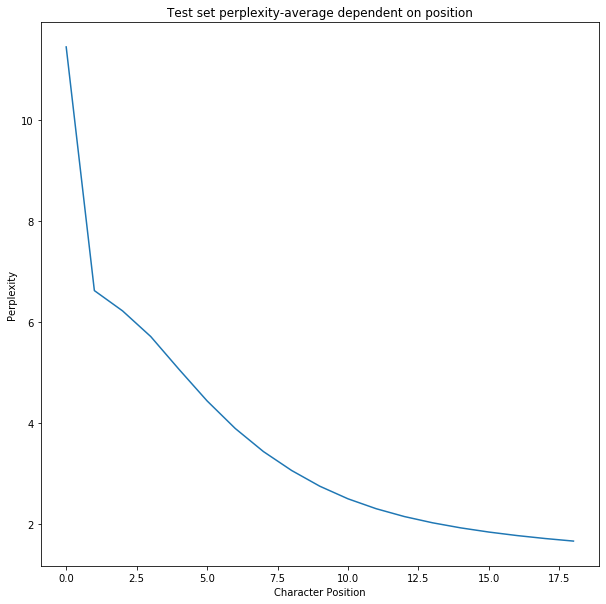

In [0]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(19),tmp)
plt.xlabel("Character Position")
plt.ylabel("Perplexity")
plt.title("Test set perplexity-average dependent on position")


#Characterwise Accuracy

In [0]:
def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def normalize_sizes(y_pred, y_true):
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def accuracy_character(y_pred, y_true, mask_index,pos):
  return(compute_accuracy(y_pred[:,:pos,:], y_true[:,:pos], mask_index))

In [0]:
tmp=[]
for j in range(1,all_pred.shape[1]+1):
  print(accuracy_character(all_pred.to(args.device),true.to(args.device),mask_index,j))
  tmp.append(accuracy_character(all_pred.to(args.device),true.to(args.device),mask_index,j))

8.510044642857142
19.777715773809522
21.618353743605642
26.159757801583606
31.63724277521646
37.40744868875691
42.062230297524415
45.027547663403226
46.75992802655921
47.747000334328064
48.276832701015785
48.493374257039854
48.57952127982884
48.61401292454205
48.630236794171225
48.63647401651287
48.63896848137536
48.63959205973411
48.63959205973411


Text(0.5, 1.0, 'Test set accuracy-average dependent on position')

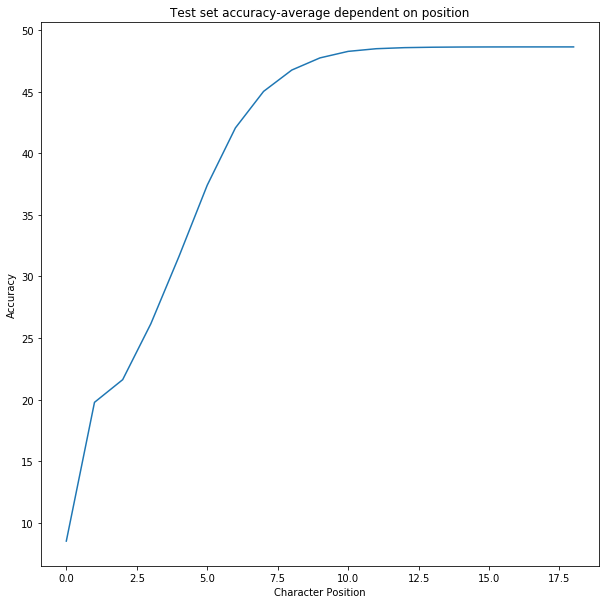

In [0]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(19),tmp)
plt.xlabel("Character Position")
plt.ylabel("Accuracy")
plt.title("Test set accuracy-average dependent on position")


**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

## all the below mentioned details are for the whole text with a hidden size of 2056

In [0]:
print("Test loss: {};".format(train_state['test_loss']))
print("TEXT perplexity: {};".format(perplexity_all(all_pred.to(args.device),true.to(args.device),mask_index))) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))


Test loss: 2.298266649246216;
TEXT perplexity: 1.660618782043457;
Test Accuracy: 36.294526799211226


## Inference (Hidden size 2056)
To see the names that the model generates:

In [0]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Cassidy
Tsutaba
Roshapley
Keisllet
Botros
TshiQskid
Dho
Mlastov
Vihscdyan
Ling


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [0]:
# concatnating all the outputs from test set in all_pred

all_pred=torch.LongTensor()
true=torch.LongTensor()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)

  
for batch_index, batch_dict in enumerate(batch_generator):
      # compute the output
      

      # stacking tensors to calculate perplexity
      all_pred=torch.cat((all_pred,batch_dict['x_data'].detach().cpu()))
      true=torch.cat((true,batch_dict['y_target'].detach().cpu()))

  

In [0]:
a=[2,4,8,16,64,128,256,512,1024,2056]
perp=[]
pre="./model_"
post='.pth'
for i in a:

  path=pre+str(i)+post
  args.rnn_hidden_size=i
  model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
  model.load_state_dict(torch.load(path))
  model.to(args.device)
  model.eval()
  y_pred = model(x_in=all_pred.to(args.device))
  temp=[]
  for j in range(1,y_pred.shape[1]+1):
    temp.append(perplexity_context(y_pred,true.to(args.device),mask_index,j).data)
  perp.append(temp)
    
    
    

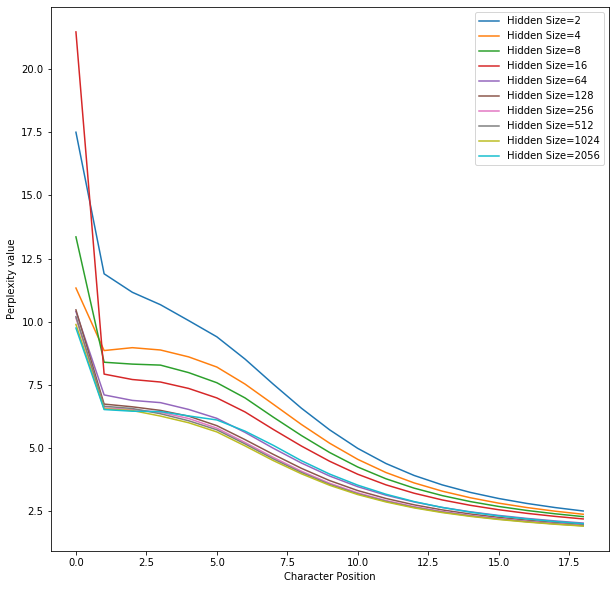

In [0]:
plt.figure(figsize=(10,10))
plt.xlabel("Character Position")
plt.ylabel("Perplexity value")
for i,val in enumerate(perp):
  plt.plot(np.arange(len(val)),val,label="Hidden Size={}".format(a[i]))
  plt.legend()